In [ ]:
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.subplots as sp

def expected_improvement(X, mu, sigma, xi=0.01):
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    mu_sample_opt = np.max(mu)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

def kernel(a, b, l=1.0):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/l**2) * sqdist)

def f(x, y):
    return (np.sin(x) + np.sin(y)) / 2

QUANTIZATION_FACTOR = 2
def xy_discrete(xy):
    return np.round(xy / QUANTIZATION_FACTOR) * QUANTIZATION_FACTOR

def predict(x_train, y_train, x_test, kernel):
    K = kernel(x_train, x_train)
    K_star = kernel(x_test, x_train)
    mu_star = K_star @ np.linalg.inv(K) @ y_train
    var_star = np.diag(kernel(x_test, x_test) - K_star @ np.linalg.inv(K) @ K_star.T)
    return mu_star, var_star

n_iterations = 2
np.random.seed(42)
INTERVAL=10
x_train = xy_discrete(np.random.uniform(0, INTERVAL, size=(2, 2)))
y_train = f(x_train[:, 0], x_train[:, 1])

x1_test = np.linspace(0, INTERVAL, 100)
x2_test = np.linspace(0, INTERVAL, 100)
x_test = np.array([[x1, x2] for x1 in x1_test for x2 in x2_test])

mu_star, var_star = predict(x_train, y_train, x_test, kernel)

for iteration in range(n_iterations):
    EI = expected_improvement(x_test, mu_star, var_star, xi=0.01)
    x_next = xy_discrete(x_test[np.argmax(EI)])
    y_next = f(x_next[0], x_next[1])
    x_train = np.vstack((x_train, x_next))
    y_train = np.append(y_train, y_next)
    print(f"Iteration {iteration+1}: x_next = {x_next}, y_next = {y_next}")
    mu_star, var_star = predict(x_train, y_train, x_test, kernel)

# Create a grid of points
X, Y = np.meshgrid(x1_test, x2_test)
Z_true = (np.sin(X) + np.sin(Y)) / 2
Z_pred = mu_star.reshape(100, 100)

fig = sp.make_subplots(rows=1, cols=2,
    subplot_titles=("True Function", "Model's Prediction"),
    specs=[[{'type': 'surface'}, {'type': 'surface'}]])

fig.add_trace(
    go.Surface(x=X, y=Y, z=Z_true, colorscale='viridis'),
    row=1, col=1)

fig.add_trace(
    go.Surface(x=X, y=Y, z=Z_pred, colorscale='viridis'),
    row=1, col=2)

fig.update_layout(height=800, width=1200,
    scene=dict(xaxis_title='X Axis', yaxis_title='Y Axis', zaxis_title='Z Axis',
    aspectratio=dict(x=1, y=1, z=0.7),
    camera=dict(eye=dict(x=1.2, y=1.2, z=0.6))))

fig.show()


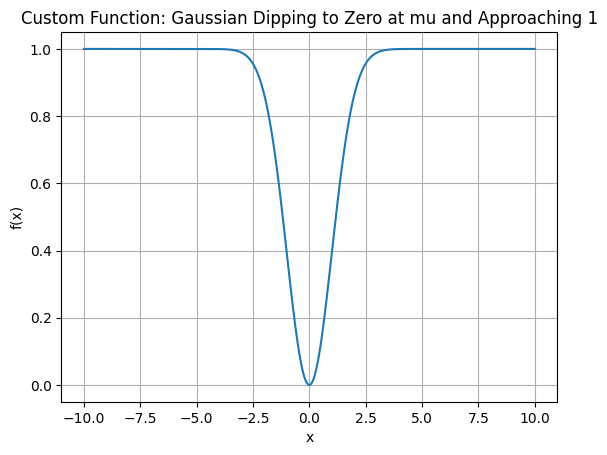

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

def custom_function(x, mu, sigma):
    return 1 - gaussian(x, mu, sigma)

# Define the range of x values
x = np.linspace(-10, 10, 1000)

# Define the parameters for the custom function
mu = 0
sigma = 1

# Calculate the corresponding y values
y = custom_function(x, mu, sigma)

# Plot the custom function
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Function: Gaussian Dipping to Zero at mu and Approaching 1')
plt.grid(True)
plt.show()
